In [ ]:
#CREDITS TO:
#https://github.com/gurkandemir/Bag-of-Visual-Wordsimport

import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import cv2
import time
from google.colab.patches import cv2_imshow
# !pip install opencv-python-headless
!pip install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17

In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
%ls
%cd '/content/drive/MyDrive/Colab Notebooks/V&P/assignment'
%ls

Mounted at /content/drive
drive/  sample_data/
/content/drive/MyDrive/Colab Notebooks/V&P/assignment
2.jfif                   exercise_11.ipynb  im4.jpg
7.jfif                   exercise_12.ipynb  ImageProcessing_assignment.pdf
8_1im.png                exercise_13.ipynb  isaac.png
8_2im.png                exGenerator.pyc    Lenna.png
BoW.py                   frame1.png         Photos/
Dataset/                 gen_img/           simple.jpg
Distorted/               im1.jpg            templateAssignment.zip
ExampleGeneration.ipynb  im2.jpg            try1-7Exercise.ipynb
exercise_10.ipynb        im3.jpg


# load data and definition of evaluation functions

In [ ]:
def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(path +'/'+ folder):
            images.append(path+'/' + folder  + '/'+  file)

    if(train is True):
        np.random.shuffle(images)
    
    return images
  
def readImage(img_path):
    img = cv2.imread(img_path) 
    return cv2.resize(img,(150,150))


def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions, feature_extractor):
    np.set_printoptions(precision=2)

    class_names = ["city", "face", "green", "house_building", "house_indoor", "office", "sea"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization (' + feature_extractor +')')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix (' + feature_extractor +')')

    plt.show()

def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

# classification model


In [ ]:
def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    class_weight = {
        0: (807 / (7 * 140)),
        1: (807 / (7 * 140)),
        2: (807 / (7 * 133)),
        3: (807 / (7 * 70)),
        4: (807 / (7 * 42)),
        5: (807 / (7 * 140)),
        6: (807 / (7 * 142)) 
    }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm

# detectors and descriptors

In [ ]:
def harrisDetection(img_color):

    # convert to gray-scale
    img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
        # modify the data type
    # setting to 32-bit floating point
    img = np.float32(img)


    # get the corner distribution probability, thresholded corner response
    dst = cv2.cornerHarris(img,2,3,0.04)

    # it's possible to use dilation here (Results are marked through the dilated corners)
    # dst = cv2.dilate(dst,None)

    # Threshold for an optimal value, it may vary depending on the image.
    # Reverting back to the original image with optimal threshold value (non maximal suppresion)
    non_max_sup = dst> 0.1*dst.max() 
    img_color[non_max_sup]=[0,0,255] # mark with red dot 

    # creation of the keypoints
    keypoints = np.argwhere(non_max_sup)
    # list of keypoints objects or a numpy array
    kps = [cv2.KeyPoint(float(x[1]), float(x[0]), 1) for x in keypoints]
    corners = np.array([[float(x[1]), float(x[0])] for x in keypoints])

    return kps, corners

def get_corners_HCD(image):
    kps, corners  = harrisDetection(image)
    return corners, kps


def get_descriptors_SIFT(image,sift):
    kp = sift.detect(image,None)  # list of keypoints
    kp, des = sift.compute(image, kp)
    return des, kp

def get_descriptors_FAST(image,descriptor):
    img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    fast = cv2.FastFeatureDetector_create()
    fast.setNonmaxSuppression(True)
    fast.setThreshold(30)
    # print( "Threshold: {}".format(fast.getThreshold()) )
    # print( "nonmaxSuppression:{}".format(fast.getNonmaxSuppression()) )
    kp = fast.detect(img,None)
    kp, des = descriptor.compute(image,  kp)
    return des, kp

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 
    return descriptors

# BOW functions

In [ ]:
def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters, second_dim):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, second_dim)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters, feature_extractor):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])
    
    plt.figure(figsize=(15,7))
    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated (" + feature_extractor +")")
    plt.xticks(x_scalar + 0.4, x_scalar)

    plt.show()

# train and test 

In [ ]:
def trainModel(path, no_clusters, kernel, feature_extractor):
    images = getFiles(True, path)

    descriptorExtractor = cv2.xfeatures2d.SIFT_create()

    print("Train images path detected.")
    descriptor_list = []
    train_labels = np.array([])
    label_count = 7
    image_count = len(images)
    startTime = time.time()
    for img_path in images:
        if("city" in img_path):
            class_index = 0
        elif("face" in img_path):
            class_index = 1
        elif("green" in img_path):
            class_index = 2
        elif("house_building" in img_path):
            class_index = 3
        elif("house_indoor" in img_path):
            class_index = 4
        elif("office" in img_path):
          class_index = 5
        else:
          class_index = 6

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = None
        if feature_extractor == 'SIFT':
          des, _ = get_descriptors_SIFT(img,descriptorExtractor)
        elif feature_extractor == 'Harris corner detector':
          corners, kp  = get_corners_HCD(img)
          des = corners
        elif feature_extractor == 'FAST':
          des, _ = get_descriptors_FAST(img,descriptorExtractor)
        descriptor_list.append(des)
    
    print("End creation descriptors, time: {} [s], with {} elements".format((time.time() -startTime), len(descriptor_list)))
    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    if feature_extractor == 'Harris corner detector':
      im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters, 2)
    else:
      im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters, 128)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters, feature_extractor)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel, feature_extractor):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "city",
        "1": "face",
        "2": "green",
        "3": "house_building",
        "4": "house_indoor",
        "5": "office",
        "6": "sea"
    }

    descriptorExtractor = cv2.xfeatures2d.SIFT_create()
    
    for img_path in test_images:
        img = readImage(img_path)
        des = None
        if feature_extractor == "SIFT":
          des, _ = get_descriptors_SIFT(img,descriptorExtractor)
        elif feature_extractor == "Harris corner detector":
          corners, kp  = get_corners_HCD(img)
          des = corners
        elif feature_extractor == 'FAST':
          des, _ = get_descriptors_FAST(img,descriptorExtractor)
          pass

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("city" in img_path):
                true.append("city")
            elif("face" in img_path):
                true.append("face")
            elif("green" in img_path):
                true.append("green")
            elif("house_building" in img_path):
                true.append("house_building")
            elif("house_indoor" in img_path):
                true.append("house_indoor")
            elif("office" in img_path):
                true.append("office")
            else:
                true.append("sea")

    descriptors = vstackDescriptors(descriptor_list)

    if feature_extractor == 'Harris corner detector':
      test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters, 2)
    else:
      test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters, 128)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions, feature_extractor)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")

# Launching

Train images path detected.
End creation descriptors, time: 11.371143579483032 [s], with 807 elements
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


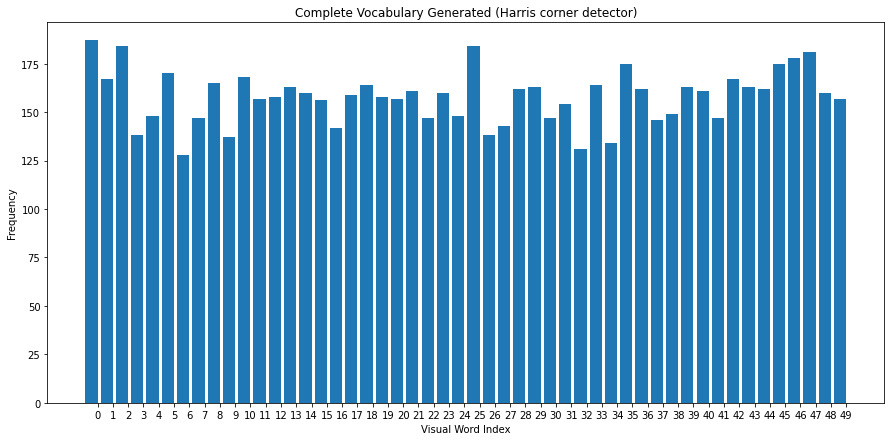

Features histogram plotted.
0.15 0.1
SVM fitted.
Training completed.
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[18  0  4  4  1  1  2]
 [ 1 21  5  1  0  0  2]
 [ 3  3 10  3  7  3  1]
 [ 6  1  6 12  0  1  4]
 [ 3  7  4  6  1  5  4]
 [ 2  2  5  4  3 11  3]
 [ 2  6  1  2  0  3 16]]
Normalized confusion matrix
[[0.6  0.   0.13 0.13 0.03 0.03 0.07]
 [0.03 0.7  0.17 0.03 0.   0.   0.07]
 [0.1  0.1  0.33 0.1  0.23 0.1  0.03]
 [0.2  0.03 0.2  0.4  0.   0.03 0.13]
 [0.1  0.23 0.13 0.2  0.03 0.17 0.13]
 [0.07 0.07 0.17 0.13 0.1  0.37 0.1 ]
 [0.07 0.2  0.03 0.07 0.   0.1  0.53]]


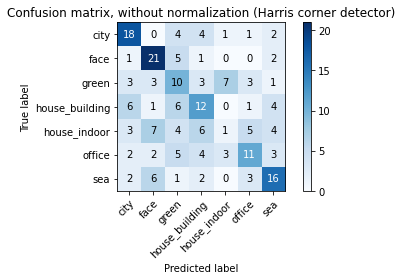

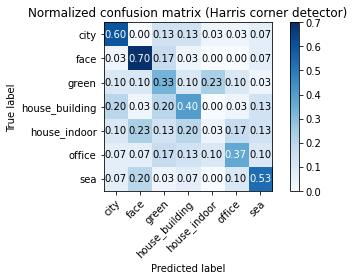

Confusion matrixes plotted.
accuracy score: 0.424
Accuracy calculated.
Execution done.


In [ ]:
# 3 different feature extractor methods for the execution: Harris corner detector, SIFT and FAST

kmeans, scale, svm, im_features = trainModel("./Dataset/train", 50, 'linear', 'Harris corner detector')
testModel("./Dataset/test", kmeans, scale, svm, im_features, 50, 'linear', 'Harris corner detector')  

Train images path detected.
End creation descriptors, time: 26.07727861404419 [s], with 807 elements
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


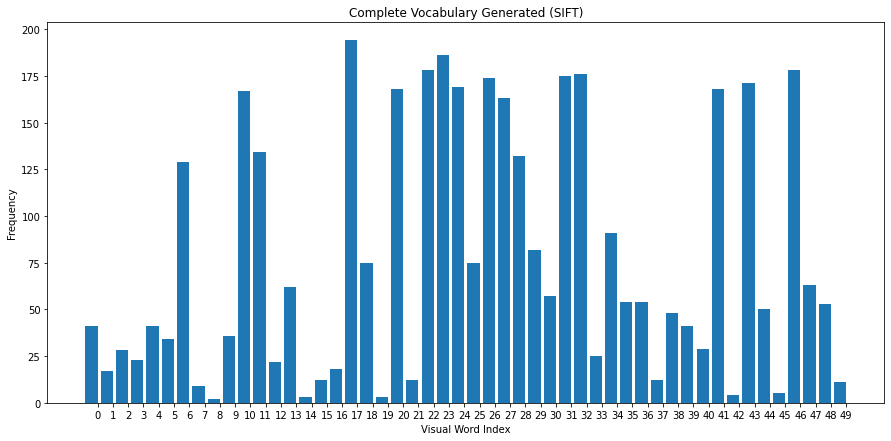

Features histogram plotted.
0.15 0.1
SVM fitted.
Training completed.
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[18  0  7  0  3  0  2]
 [ 0 22  4  0  2  0  2]
 [ 4  5 18  1  1  0  1]
 [ 6  4  2 14  1  3  0]
 [ 3  2  1  3 10 11  0]
 [ 2  1  3  5  3 16  0]
 [ 1  1  7  0  0  1 20]]
Normalized confusion matrix
[[0.6  0.   0.23 0.   0.1  0.   0.07]
 [0.   0.73 0.13 0.   0.07 0.   0.07]
 [0.13 0.17 0.6  0.03 0.03 0.   0.03]
 [0.2  0.13 0.07 0.47 0.03 0.1  0.  ]
 [0.1  0.07 0.03 0.1  0.33 0.37 0.  ]
 [0.07 0.03 0.1  0.17 0.1  0.53 0.  ]
 [0.03 0.03 0.23 0.   0.   0.03 0.67]]


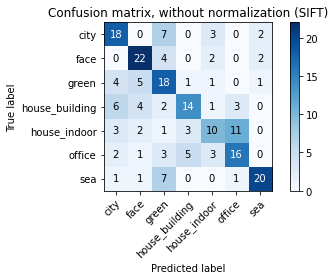

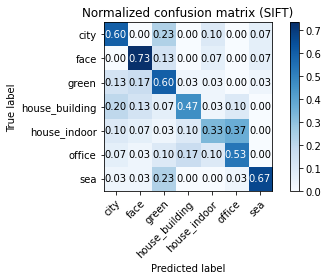

Confusion matrixes plotted.
accuracy score: 0.562
Accuracy calculated.
Execution done.


In [ ]:
kmeans, scale, svm, im_features = trainModel("./Dataset/train", 50, 'linear', 'SIFT')
testModel("./Dataset/test", kmeans, scale, svm, im_features, 50, 'linear', 'SIFT')

Train images path detected.
End creation descriptors, time: 30.745527505874634 [s], with 807 elements
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


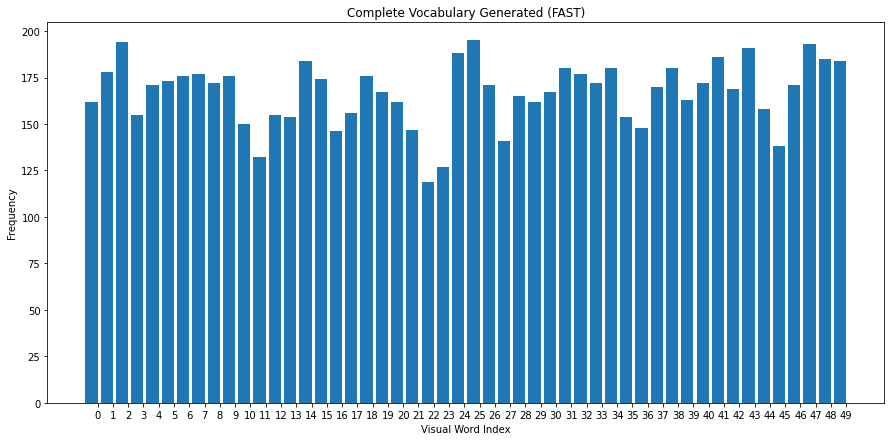

Features histogram plotted.
0.2 0.1
SVM fitted.
Training completed.
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[17  0 10  0  2  1  0]
 [ 0 23  0  2  3  2  0]
 [ 3  0 16  0  2  0  9]
 [ 2  0  0 18  2  5  3]
 [ 4  3  6  2  6  8  1]
 [ 1  0  1  3  1 24  0]
 [ 2  2  6  0  0  1 19]]
Normalized confusion matrix
[[0.57 0.   0.33 0.   0.07 0.03 0.  ]
 [0.   0.77 0.   0.07 0.1  0.07 0.  ]
 [0.1  0.   0.53 0.   0.07 0.   0.3 ]
 [0.07 0.   0.   0.6  0.07 0.17 0.1 ]
 [0.13 0.1  0.2  0.07 0.2  0.27 0.03]
 [0.03 0.   0.03 0.1  0.03 0.8  0.  ]
 [0.07 0.07 0.2  0.   0.   0.03 0.63]]


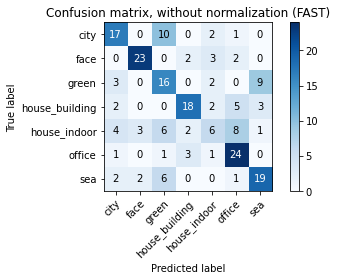

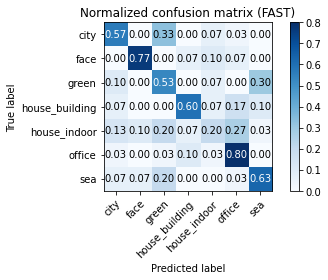

Confusion matrixes plotted.
accuracy score: 0.586
Accuracy calculated.
Execution done.


In [ ]:
kmeans, scale, svm, im_features = trainModel("./Dataset/train", 50, 'linear', 'FAST')
testModel("./Dataset/test", kmeans, scale, svm, im_features, 50, 'linear', 'FAST')

# [test] detector and descriptors

807


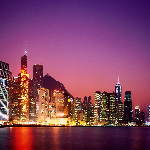

number of descriptors: 135


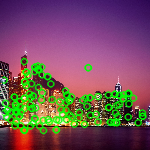

True

In [ ]:
# test SIFT feature detection

images_path = getFiles(False, "./Dataset/train")
print(len(images_path))
image_path = images_path[0]
img = readImage(image_path) # color image
cv2_imshow(img)
cv2.imwrite("sample_image.jpg", img)

sift = cv2.xfeatures2d.SIFT_create()

des, kp = get_descriptors_SIFT(img,sift)
print("number of descriptors: {}".format(len(des)))
out_img = None
out_img= cv2.drawKeypoints(img,kp, outImage = out_img,color=(0,255,0))
cv2_imshow(out_img)
cv2.imwrite("sample_image_sift.jpg", out_img)

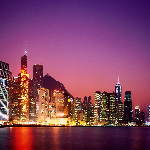

number of corners: 218


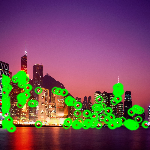

True

In [ ]:
# test harris corner detection

# test - detection
images_path = getFiles(False, "./Dataset/train")
image_path = images_path[0]
img = readImage(image_path) # color image
cv2_imshow(img)


# test - descriptors

corners, kp = get_corners_HCD(img)
print("number of corners: {}".format(len(corners)))
out_img = None
out_img= cv2.drawKeypoints(img,kp, outImage = out_img,color=(0,255,0))
cv2_imshow(out_img)
cv2.imwrite("sample_image_harris.jpg", out_img)

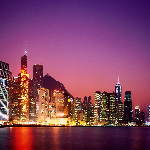

number of descriptors: 403


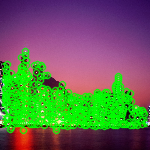

True

In [ ]:
# test 3

# test - detection
images_path = getFiles(False, "./Dataset/train")
image_path = images_path[0]
img = readImage(image_path) # color image
cv2_imshow(img)

# test - descriptors
sift = cv2.xfeatures2d.SIFT_create()
des, kp = get_descriptors_FAST(img,sift)
print("number of descriptors: {}".format(len(des)))
out_img = None
out_img= cv2.drawKeypoints(img,kp, outImage = out_img,color=(0,255,0))
cv2_imshow(out_img)
cv2.imwrite("sample_image_fast.jpg", out_img)